## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the combined dataset and inspect it

In [2]:
os.chdir('C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya')
print(os.getcwd())

C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya


#### Drop rows where envProduction is NaN

In [3]:
# print number of rows in the dataset
data = pd.read_csv('combined4.csv', index_col=0)
print(len(data))
# drop rows where envProduction is NaN 
data.dropna(subset=['envProduction'], inplace=True)
print(len(data))

9243
6511


#### Drop rows where -98/-99 codes occur

In [4]:
col_list = ['Neg_wellb_1', 'Neg_wellb_2', 'Neg_wellb_3', 'Neg_wellb_4', 'Pos_wellb_1', 'Pos_wellb_2', 'Pos_wellb_3', 'Pos_wellb_4',
             'Fut_Gen_1', 'Fut_Gen_2', 'Fut_Gen_3', 'Fut_Gen_4', 'Gov_resp_1', 'Gov_resp_2', 'Gov_resp_3', 'Gov_resp_4',
             'Com_coord_1', 'Com_coord_2', 'Com_coord_3', 'Com_coord_4',
             'Risk_social_1', 'Risk_social_2', 'Risk_social_3', 'Risk_social_4', 'Risk_punish_1', 'Risk_punish_2', 'Risk_punish_3', 'Risk_punish_4',
             'Com_trust1_1', 'Com_trust1_2', 'Com_trust1_3', 'Com_trust1_4', 'Com_trust2_1', 'Com_trust2_2', 'Com_trust2_3', 'Com_trust2_4',
             'Trust_govt_1', 'Trust_govt_2', 'Trust_govt_3', 'Trust_govt_4',
             'Trust_natpark_1', 'Trust_natpark_2', 'Trust_natpark_3', 'Trust_natpark_4', 'Depend_on_others_1', 'Depend_on_others_2', 'Depend_on_others_3', 'Depend_on_others_4',
             'Effects_on_others_1', 'Effects_on_others_2', 'Effects_on_others_3', 'Effects_on_others_4',
             'Effects_on_next_gen_1', 'Effects_on_next_gen_2', 'Effects_on_next_gen_3', 'Effects_on_next_gen_4']
for col in col_list:
    data[col] = data[col].replace(-98, np.NaN)
    data[col] = data[col].replace(-99, np.NaN)

In [5]:
np.unique([x[:-2] for x in data.columns.values])

array(['Age', 'Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others',
       'Education', 'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
       'Game', 'Game_goal_1', 'Game_goal_2', 'Game_goal_3', 'Game_goal_4',
       'Gender', 'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Rel1', 'Rel2',
       'Rel3', 'RespHOH', 'Risk_punish', 'Risk_social', 'Roun',
       'Treatmen', 'Trust_govt', 'Trust_natpark', 'count', 'envProducti',
       'primary_farming', 'primary_priv_tour', 'secondary_farming',
       'secondary_priv_tour', 'subsi'], dtype='<U19')

In [6]:
for col in ['Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others', 'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
            'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Risk_punish', 'Risk_social', 'Trust_govt', 'Trust_natpark', 
            'primary_farming', 'primary_priv_tour', 'secondary_farming', 'secondary_priv_tour']:
    data.dropna(subset=[col+'_1', col+'_2', col+'_3', col+'_4'], inplace=True, how='all')
# print size of the data again
len(data)

6511

## Compute group statistics (mean, variance, min, max)

In [7]:
for col in ['Age', 'Education', 'Gender', 'Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others',
           'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
           'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Risk_social', 'Risk_punish', 'Trust_govt', 'Trust_natpark',
           'primary_farming', 'primary_priv_tour', 'secondary_farming', 'secondary_priv_tour']:
    data[col+'_mean'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].mean(axis=1)
    data[col+'_var'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].var(axis=1, ddof=0)

for col in ['Game_goal_1', 'Game_goal_2', 'Game_goal_3', 'Game_goal_4']:
    # note that inner index is player number
    data[col+'_mean'] = data[['Game_goal_1_'+col[-1], 'Game_goal_2_'+col[-1], 'Game_goal_3_'+col[-1], 'Game_goal_4_'+col[-1]]].mean(axis=1)
    data[col+'_var'] = data[['Game_goal_1_'+col[-1], 'Game_goal_2_'+col[-1], 'Game_goal_3_'+col[-1], 'Game_goal_4_'+col[-1]]].var(axis=1, ddof=0)

#### One-hot encode the country column

In [8]:
# Get one hot encoding of country column
one_hot = pd.get_dummies(data['country'])
# Join the encoded dataframe
data = pd.concat([data, one_hot], axis=1)

#### Verify if grouping by GameID and Treatments would collapse the rounds to unique game level

In [9]:
print(data['Rounds'].unique())
print(data.groupby(['GameID', 'Treatments']).transform('nunique')['Rounds'].unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 7  6  8  5  9 10]


#### Get group-wise variance in environmental production outcome

In [10]:
data['varEnvProduction'] = data.groupby(['GameID', 'Treatments'])['envProduction'].transform('var')

## Compute column-wise z-scores (separately for every subset of dataset)

In [11]:
col_list = ['Age_mean', 'Age_var', 'Education_mean', 'Education_var', 'Gender_mean', 'Gender_var', 'Com_coord_mean', 
            'Com_coord_var', 'Com_trust1_mean', 'Com_trust1_var', 'Com_trust2_mean', 'Com_trust2_var',
            'Depend_on_others_mean', 'Depend_on_others_var', 'Effects_on_next_gen_mean', 'Effects_on_next_gen_var', 
            'Effects_on_others_mean', 'Effects_on_others_var', 'Fut_Gen_mean', 'Fut_Gen_var', 'Game_goal_1_mean', 
            'Game_goal_1_var', 'Game_goal_2_mean', 'Game_goal_2_var', 'Game_goal_3_mean', 'Game_goal_3_var', 'Game_goal_4_mean', 
            'Game_goal_4_var', 'Gov_resp_mean', 'Gov_resp_var', 'Neg_wellb_mean', 'Neg_wellb_var', 'Pos_wellb_mean', 
            'Pos_wellb_var', 'Risk_social_mean', 'Risk_social_var', 'Risk_punish_mean', 'Risk_punish_var',
            'Trust_govt_mean', 'Trust_govt_var', 'Trust_natpark_mean', 'Trust_natpark_var', 'primary_farming_mean', 
            'primary_farming_var', 'primary_priv_tour_mean', 'primary_priv_tour_var', 'secondary_farming_mean', 
            'secondary_farming_var', 'secondary_priv_tour_mean', 'secondary_priv_tour_var', 'varEnvProduction']
for col in col_list:
    data['z_'+col] = data.groupby('country')[col].transform(lambda x: scale(x.astype(float)))

In [12]:
exceptions = ['primary_priv_tour_mean', 'primary_priv_tour_var', 'primary_priv_tour_min', 'primary_priv_tour_max',
       'secondary_priv_tour_mean', 'secondary_priv_tour_var', 'secondary_priv_tour_min', 'secondary_priv_tour_max']

In [13]:
# define explanatory and response variables
explanatory_var = ['z_' + x for x in ['Age_mean', 'Age_var', 'Education_mean', 'Education_var', 'Gender_mean', 'Gender_var',
            'primary_farming_mean', 'primary_farming_var', 'secondary_farming_mean', 'secondary_farming_var',
            'Com_coord_mean', 'Com_coord_var', 'Com_trust1_mean', 'Com_trust1_var', 'Com_trust2_mean', 'Com_trust2_var',
            'Fut_Gen_mean', 'Fut_Gen_var',
            'Gov_resp_mean', 'Gov_resp_var', 'Neg_wellb_mean', 'Neg_wellb_var', 'Pos_wellb_mean', 'Pos_wellb_var',
            'Risk_social_mean', 'Risk_social_var', 'Risk_punish_mean', 'Risk_punish_var', 'Trust_govt_mean', 'Trust_govt_var', 
            'Trust_natpark_mean', 'Trust_natpark_var']]

response_var = 'z_varEnvProduction'

In [14]:
data[response_var].isna().any()

False

## Collapse data at unique game level

In [15]:
data = data.groupby(['GameID', 'Treatments']).first().reset_index()

#### Box-plots showing country-wise distribution of the variation in environmental production outcome

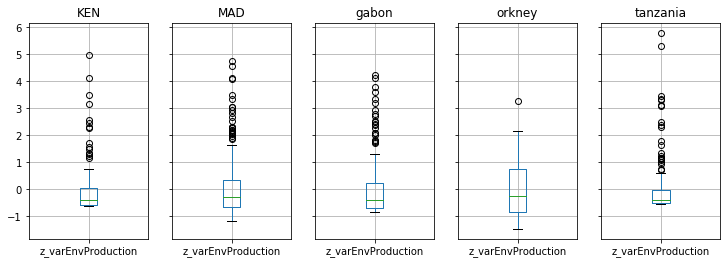

In [16]:
data[['z_varEnvProduction', 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,5))
plt.show()

## Correlation heat-map for explanatory variables

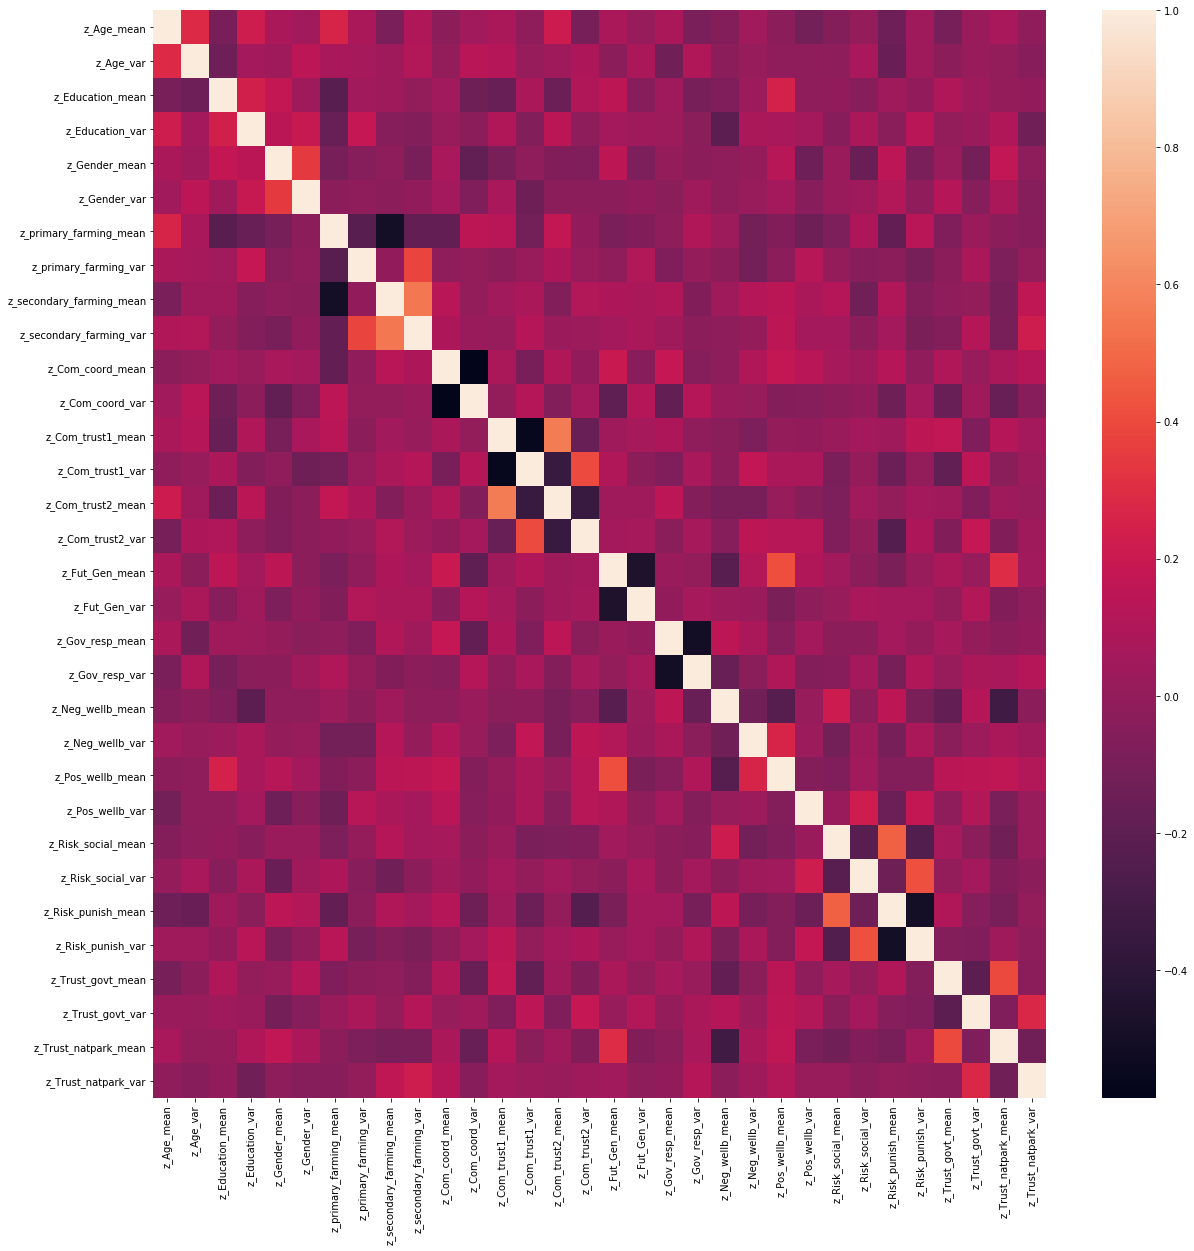

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data[explanatory_var].corr(), ax=ax)

#### Correlation between explanatory variables and response variable

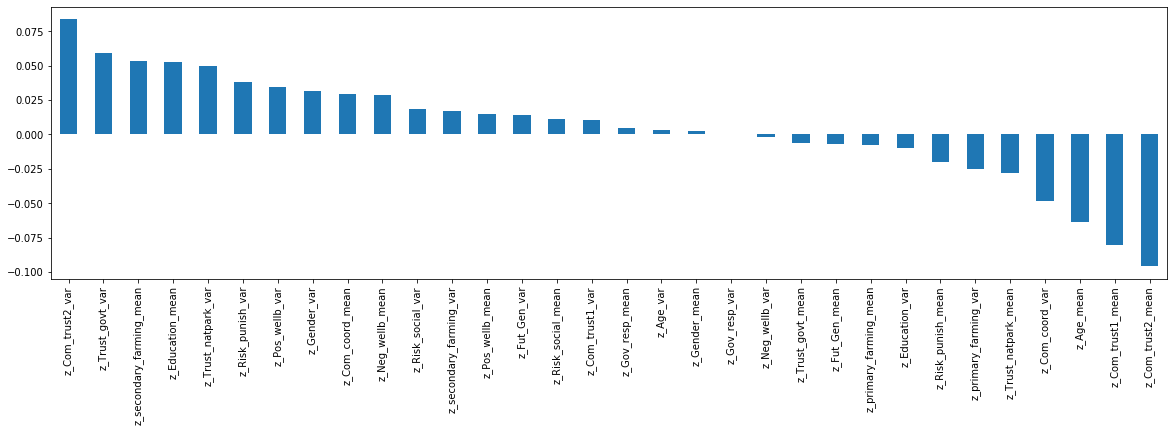

In [18]:
data[explanatory_var+[response_var]].corr()[response_var].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20,5))

In [19]:
data[explanatory_var].corr().unstack().sort_values(ascending=False)[len(explanatory_var):]

z_Com_trust1_mean         z_Com_trust2_mean           0.561929
z_Com_trust2_mean         z_Com_trust1_mean           0.561929
z_secondary_farming_var   z_secondary_farming_mean    0.548174
z_secondary_farming_mean  z_secondary_farming_var     0.548174
z_Risk_social_mean        z_Risk_punish_mean          0.468893
                                                        ...   
z_Gov_resp_mean           z_Gov_resp_var             -0.506925
z_Com_trust1_var          z_Com_trust1_mean          -0.561066
z_Com_trust1_mean         z_Com_trust1_var           -0.561066
z_Com_coord_mean          z_Com_coord_var            -0.586360
z_Com_coord_var           z_Com_coord_mean           -0.586360
Length: 992, dtype: float64

## OLS regression analysis

In [20]:
# drop duplicate rows
print(len(data))
data.drop_duplicates(inplace=True)
print(len(data))

978
978


In [21]:
# write formula
formula = response_var + ' ~ '
for var in explanatory_var:
    formula += var + ' + '
formula = formula[:-3]

In [22]:
# define and fit model
model = smformula.ols(formula, data=data)
results = model.fit(cov_type='cluster', cov_kwds={'groups': data['GameID']})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     z_varEnvProduction   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.025
Date:                Mon, 05 Apr 2021   Prob (F-statistic):              0.437
Time:                        01:30:52   Log-Likelihood:                -1367.8
No. Observations:                 978   AIC:                             2802.
Df Residuals:                     945   BIC:                             2963.
Df Model:                          32                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### ANOVA table (F-statistic and p-value)

In [23]:
table = sm.stats.anova_lm(results, typ=2) # Type 2 ANOVA DataFrame
print(table)

                              sum_sq     df         F    PR(>F)
z_Age_mean                  1.630901    1.0  1.641473  0.201466
z_Age_var                   0.561226    1.0  0.564863  0.453107
z_Education_mean            0.469375    1.0  0.472418  0.492598
z_Education_var             0.137575    1.0  0.138467  0.710166
z_Gender_mean               0.108394    1.0  0.109097  0.741488
z_Gender_var                0.658125    1.0  0.662391  0.416593
z_primary_farming_mean      1.474753    1.0  1.484312  0.224400
z_primary_farming_var       0.059397    1.0  0.059782  0.807067
z_secondary_farming_mean    2.195124    1.0  2.209353  0.138601
z_secondary_farming_var     0.036500    1.0  0.036736  0.848179
z_Com_coord_mean            0.030500    1.0  0.030698  0.861077
z_Com_coord_var             1.861641    1.0  1.873708  0.172441
z_Com_trust1_mean           4.020595    1.0  4.046655  0.045473
z_Com_trust1_var            2.562566    1.0  2.579176  0.109706
z_Com_trust2_mean           0.387649    

## Visualizing coefficients and beta coefficients

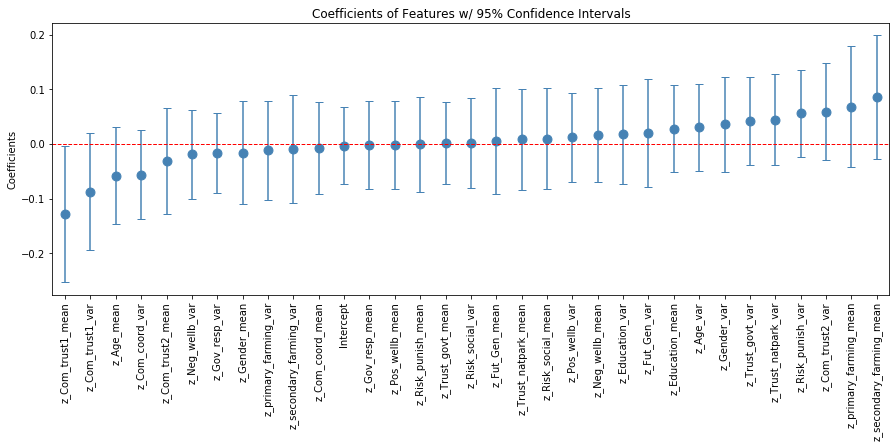

In [24]:
# Create dataframe of results summary 
coef_df = pd.DataFrame(results.summary().tables[1].data)
# Add column names
coef_df.columns = coef_df.iloc[0]
# Drop the extra row with column labels
coef_df=coef_df.drop(0)
# Set index to variable names 
coef_df = coef_df.set_index(coef_df.columns[0])
# Change datatype from object to float
coef_df = coef_df.astype(float)
# Get errors; (coef - lower bound of conf interval)
errors = coef_df['coef'] - coef_df['[0.025']
# Append errors column to dataframe
coef_df['errors'] = errors
# Sort values by coef ascending
coef_df = coef_df.sort_values(by=['coef'])
# Plot Coefficients
# x-labels
variables = list(coef_df.index.values)
# Add variables column to dataframe
coef_df['variables'] = variables
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15,5))
# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
coef_df.plot(x='variables', y='coef', kind='bar',
             ax=ax, color='none', 
             ecolor='steelblue',capsize=4,
             yerr='errors', legend=False)
# Set title & labels
plt.title('Coefficients of Features w/ 95% Confidence Intervals')
ax.set_ylabel('Coefficients')
ax.set_xlabel('')
# Coefficients
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='o', s=80, 
           y=coef_df['coef'], color='steelblue')

# Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
plt.show()

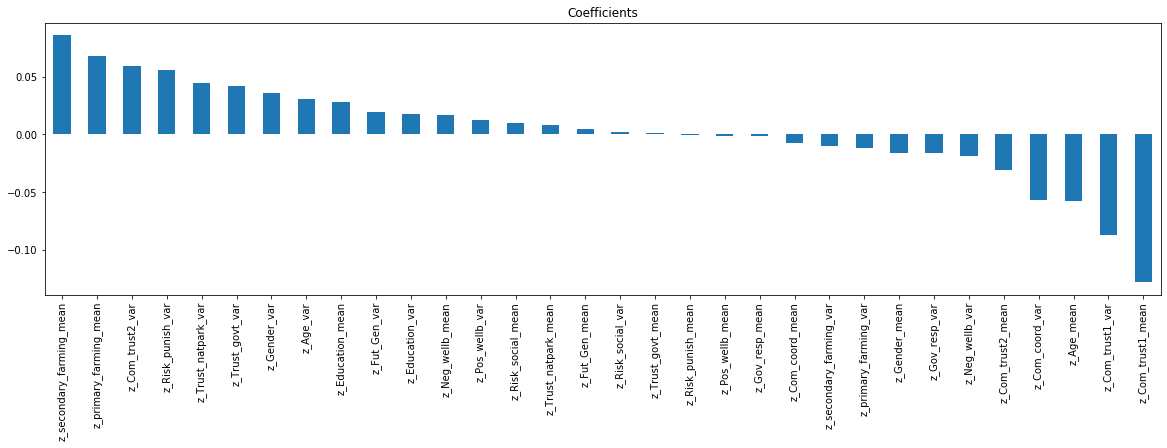

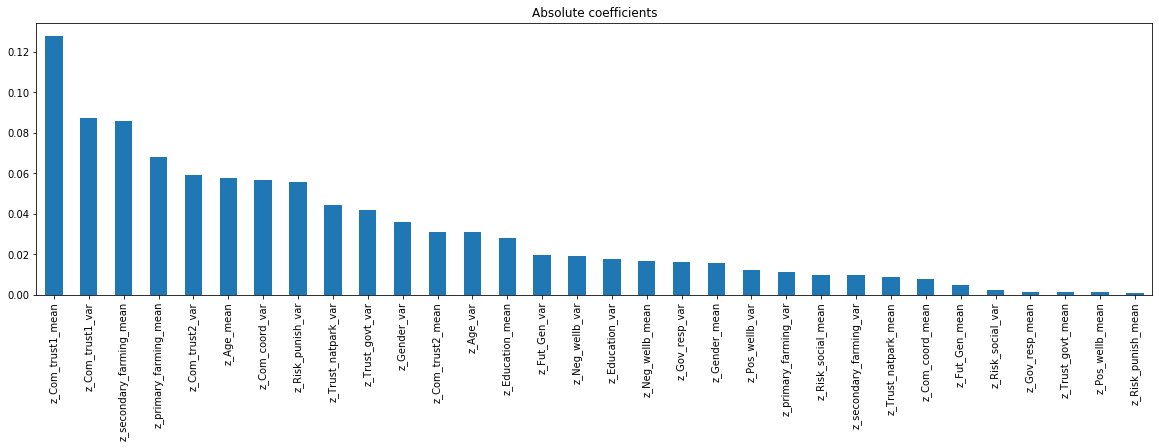

In [25]:
# plot coefficients
plt.figure(figsize=(20,5))
plt.title('Coefficients')
results.params.iloc[1:].sort_values(ascending=False).plot(kind='bar')
plt.show()

# plot absolute coefficients
plt.figure(figsize=(20,5))
plt.title('Absolute coefficients')
results.params.iloc[1:].abs().sort_values(ascending=False).plot(kind='bar')
plt.show()

## Heteroscedasticity Plot

In [26]:
results.fittedvalues

0     -0.380413
1     -0.380413
2     -0.380413
3     -0.380413
4     -0.380413
         ...   
973    0.080862
974   -0.042668
975   -0.042668
976   -0.042668
977   -0.042668
Length: 978, dtype: float64

In [27]:
data[response_var].loc[results.fittedvalues.index]

0     -0.539402
1      0.653858
2      0.192893
3     -0.100893
4     -0.205530
         ...   
973   -0.538883
974   -0.479278
975    0.295385
976   -0.544149
977   -0.414053
Name: z_varEnvProduction, Length: 978, dtype: float64

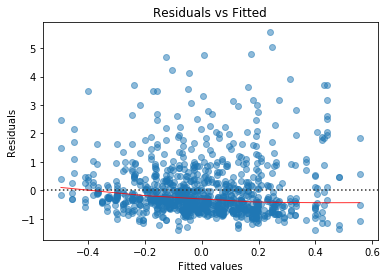

In [28]:
# model fitted values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, data[response_var], data=data[explanatory_var],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

## Reduction in R2 if a variable is removed

In [29]:
orig_r2 = results.rsquared
for var in explanatory_var:
    temp_explanatory_var = explanatory_var.copy()
    temp_explanatory_var.remove(var)
    formula = response_var + ' ~ '
    for temp_var in temp_explanatory_var:
        formula += temp_var + ' + '
    formula = formula[:-3]
    temp_model = smformula.ols(formula, data=data).fit()
    print(var, temp_model.rsquared-results.rsquared)

z_Age_mean -0.0022472529963627474
z_Age_var -0.0007380682197344335
z_Education_mean -0.0005864797123730225
z_Education_var -0.00020570804900810202
z_Gender_mean -0.00017382659541409495
z_Gender_var -0.0010045300420437053
z_primary_farming_mean -0.002145070546303529
z_primary_farming_var -7.349445091076046e-05
z_secondary_farming_mean -0.0027809917954271235
z_secondary_farming_var -3.938416276871859e-05
z_Com_coord_mean -3.264217252463286e-05
z_Com_coord_var -0.001784026460797783
z_Com_trust1_mean -0.0068942567057524995
z_Com_trust1_var -0.0038469162359898723
z_Com_trust2_mean -0.0004890333306101224
z_Com_trust2_var -0.0021517721476430607
z_Fut_Gen_mean -1.0010036514240817e-05
z_Fut_Gen_var -0.00022230605786466295
z_Gov_resp_mean -1.4088847005711003e-06
z_Gov_resp_var -0.00016875668577620573
z_Neg_wellb_mean -0.00020214731107948136
z_Neg_wellb_var -0.00029242285044828176
z_Pos_wellb_mean -1.1453122057414333e-06
z_Pos_wellb_var -0.00011645423147665923
z_Risk_social_mean -5.42096435612871

## Relative weights analysis

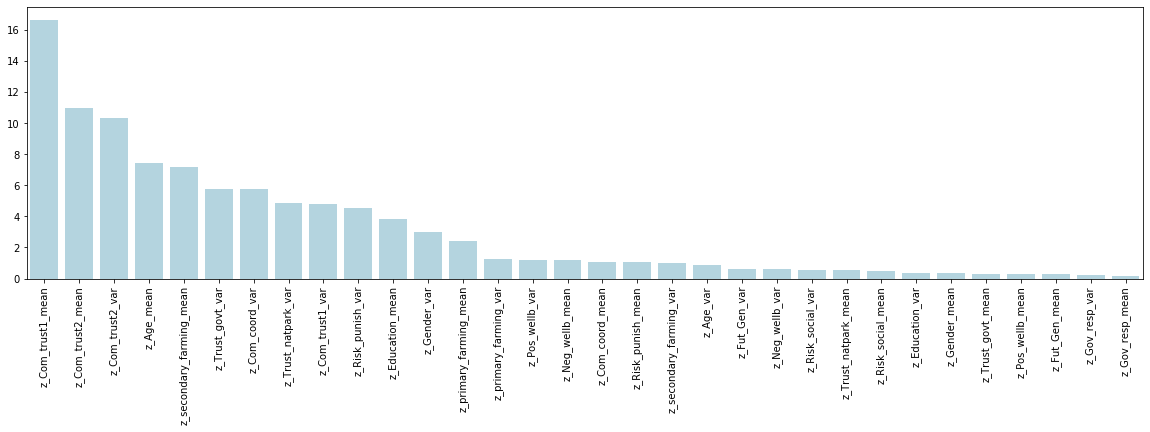

In [30]:
num_drivers = len(explanatory_var)
# Get a correlation between all of the dependent and independent variables.
corr_matrix = data[[response_var]+explanatory_var].apply(pd.to_numeric, errors = 'coerce').corr()
corr_Xs = corr_matrix.iloc[1:, 1:].copy()
corr_Xy = corr_matrix.iloc[1:, 0].copy()
# Create orthogonal predictors using eigenvectors and eigenvalues on the correlation matrix, creating a diagonal matrix
# of the square root of eigenvalues. This gets around the issue of multi-collinearity.
w_corr_Xs, v_corr_Xs = np.linalg.eig(corr_Xs)
diag_idx = np.diag_indices(len(corr_Xs))
diag = np.zeros((num_drivers, num_drivers), float)
diag[diag_idx] = w_corr_Xs
delta = np.sqrt(diag)
# Multiply the eigenvector matrix and its transposition. This allows us to treat X as the set of dependent variables, 
# regressing X onto matrix Z — itself the orthogonal counterpart of X having the least squared error. To get the partial 
# effect of each independent variable, we apply matrix multiplication to the inverse and correlation matricies.
coef_xz = v_corr_Xs @ delta @ v_corr_Xs.transpose()
coef_yz = np.linalg.inv(coef_xz) @ corr_Xy
# We then calculate the relative weight as the multiplication of the matrix in Step 2 and step 3. 
# The normalized version is then the percentage of r2 that these account for.
# Also, the sum of the squares of coef_yz above should add up to the total R2
r2 = sum(np.square(coef_yz))
raw_relative_weights = np.square(coef_xz) @ np.square(coef_yz)
normalized_relative_weights = (raw_relative_weights/r2)*100
idx = np.argsort(normalized_relative_weights)[::-1]
plt.figure(figsize=(20,5))
sns.barplot(x=corr_matrix.columns[1:][idx], y=np.sort(normalized_relative_weights)[::-1], color="lightblue")
plt.xticks(rotation=90)
plt.show()

## Scatter/regression plots for mean response_var grouped by explanatory variable

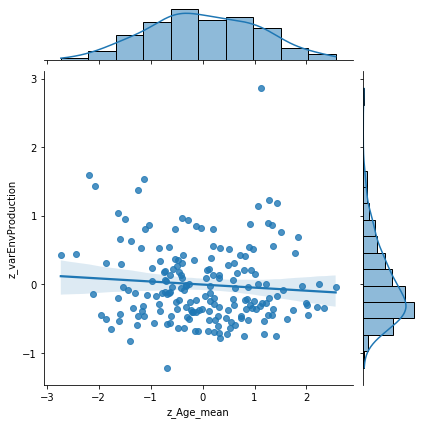

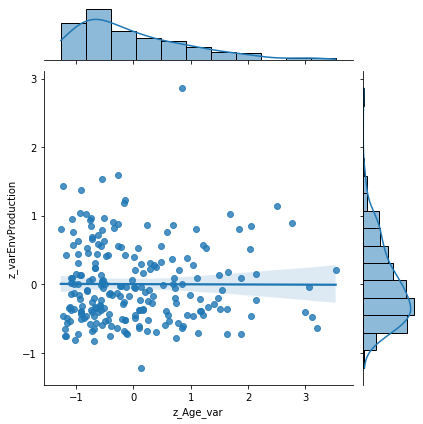

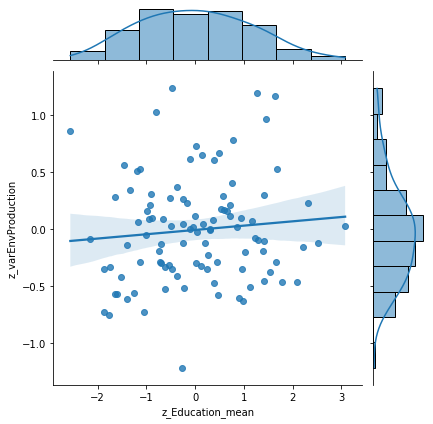

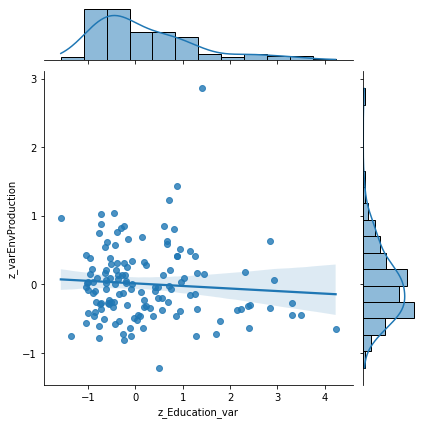

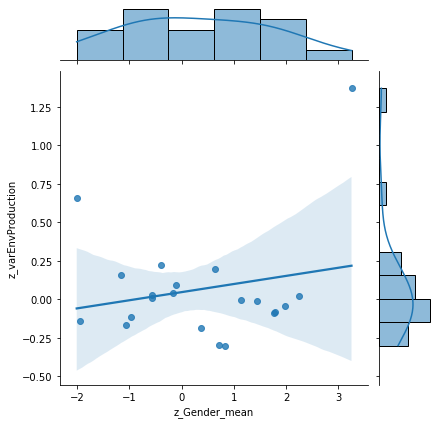

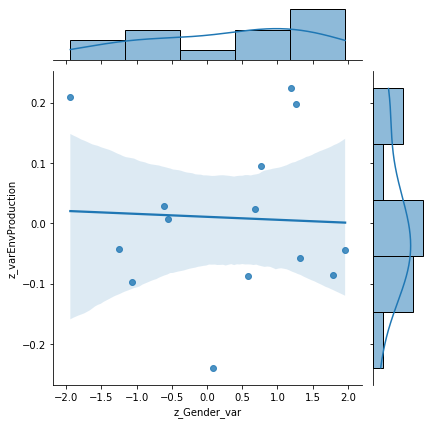

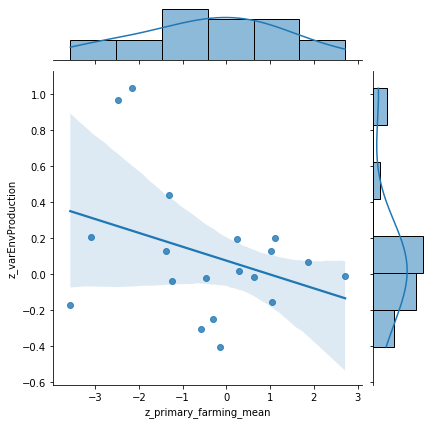

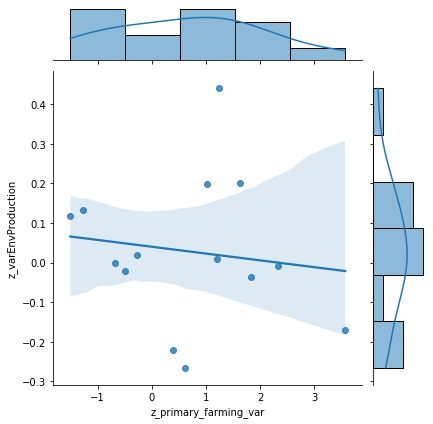

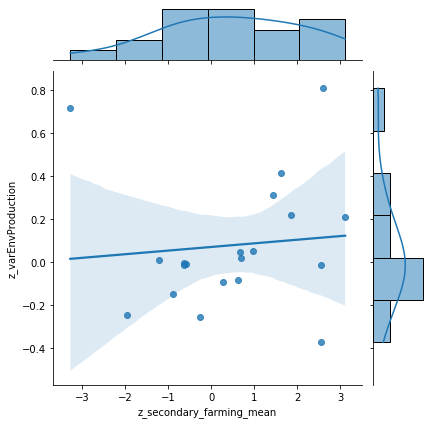

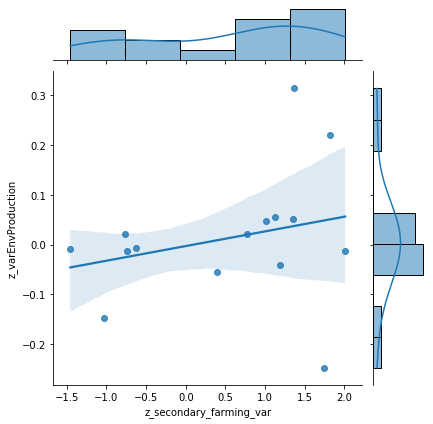

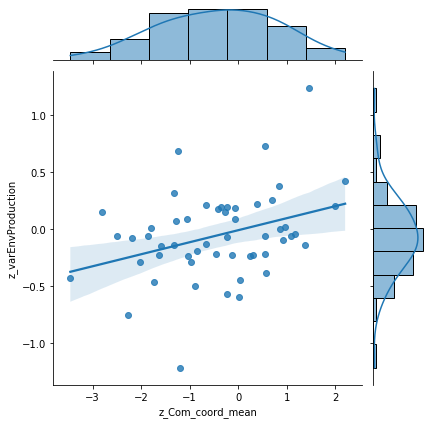

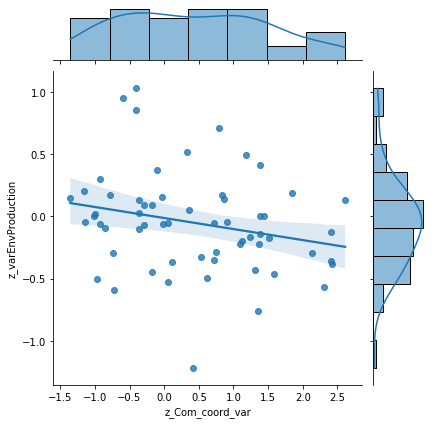

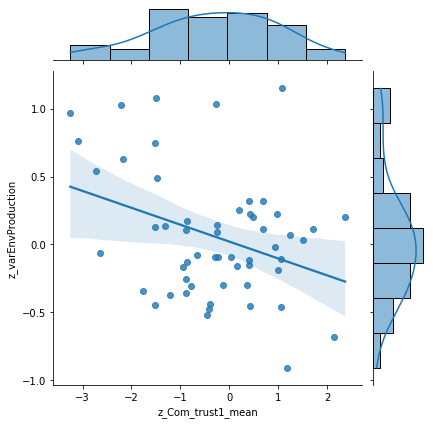

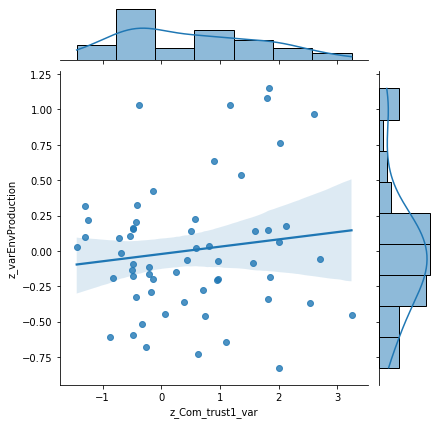

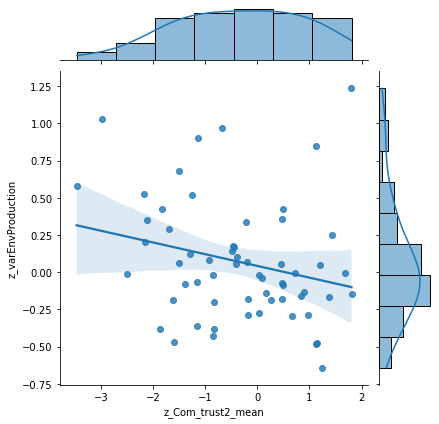

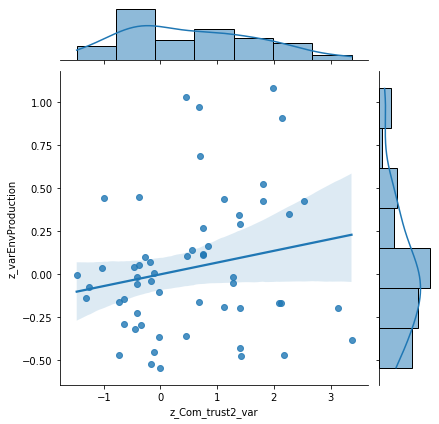

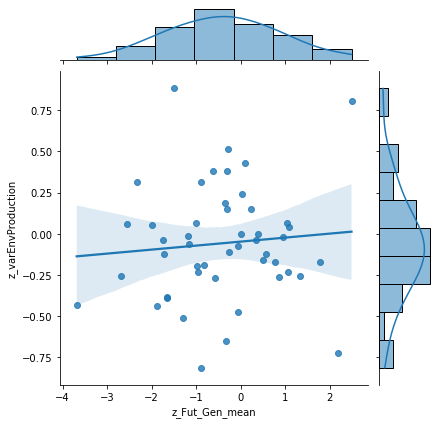

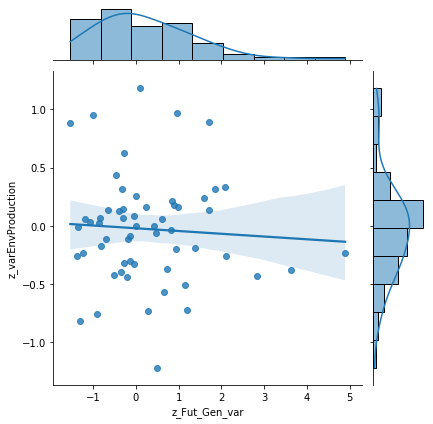

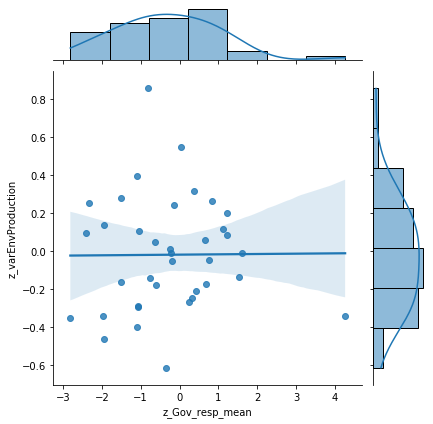

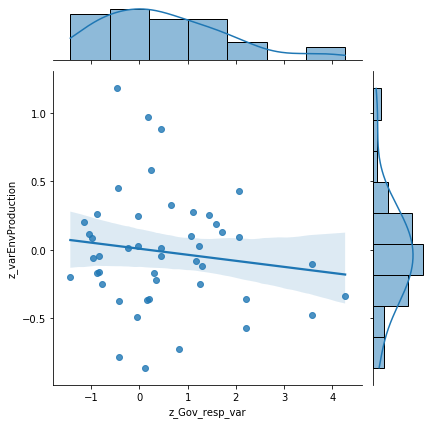

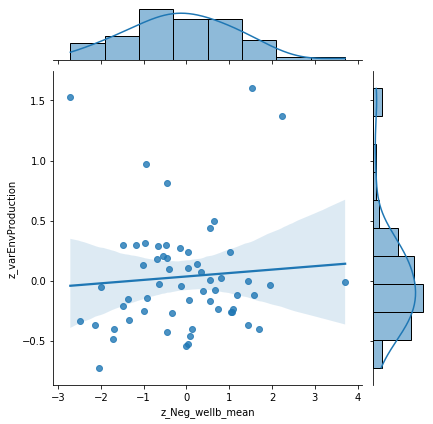

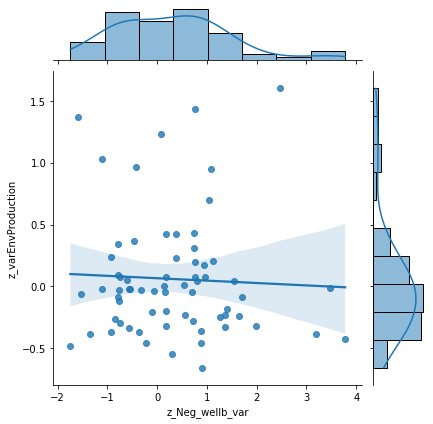

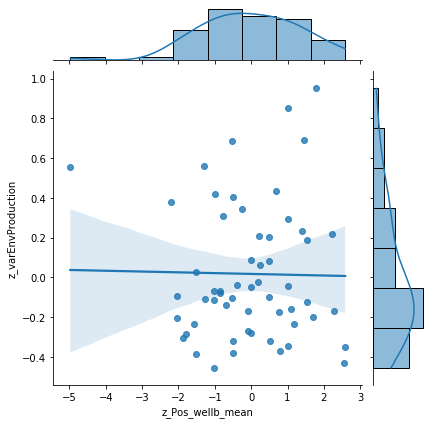

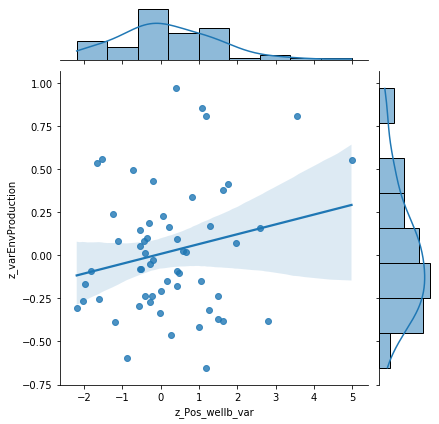

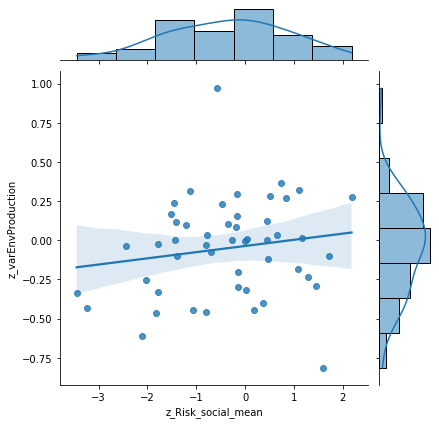

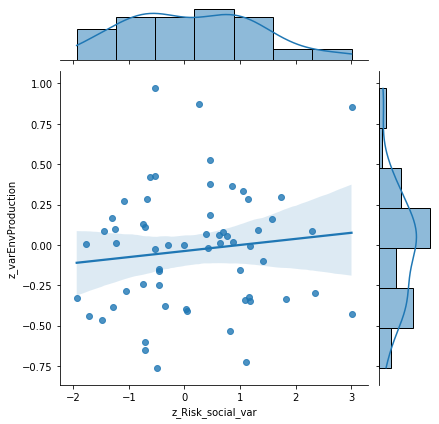

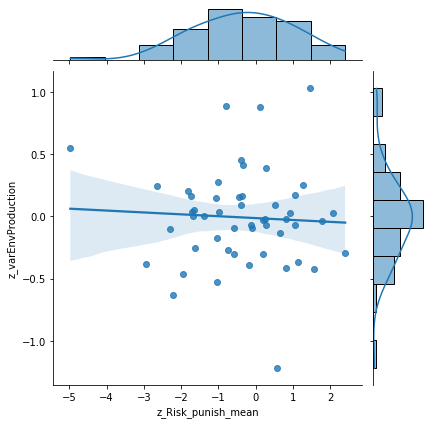

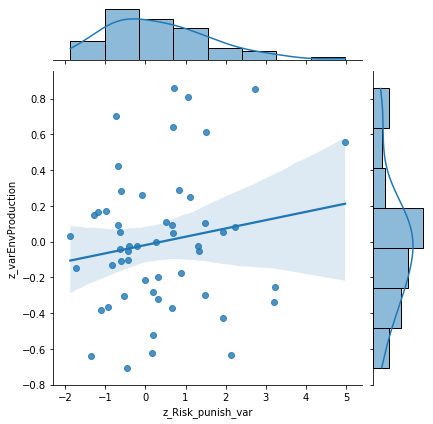

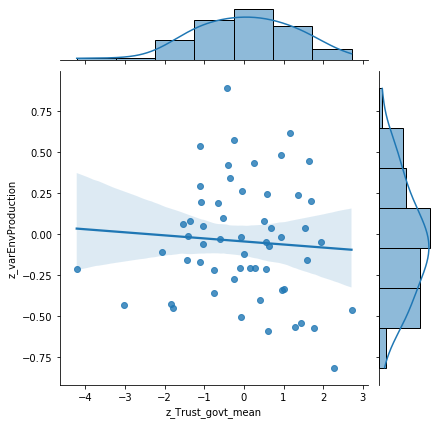

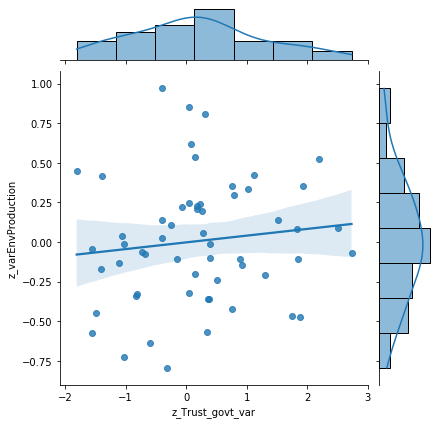

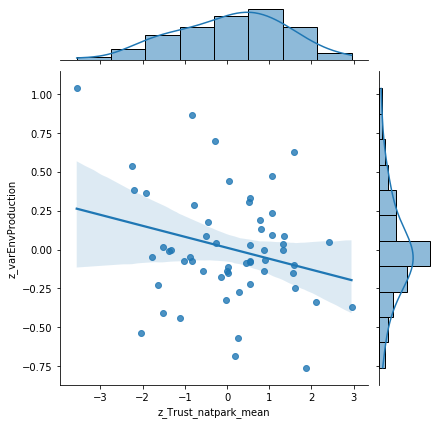

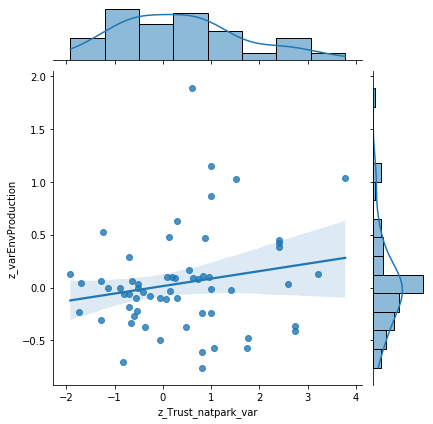

In [31]:
for var in explanatory_var:
    df = data[[var, response_var]].groupby(var).mean().reset_index()
    sns.jointplot(x=var, y=response_var, data=df, kind='reg')
    plt.show()

## Moving average and cubic regression plot for response_var against explanatory variable

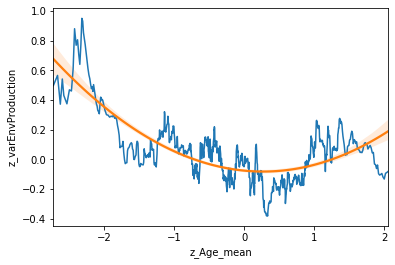

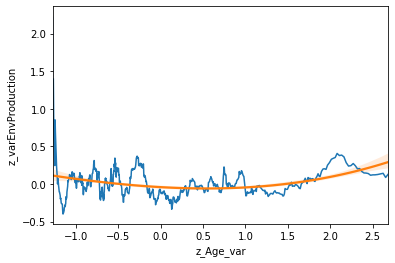

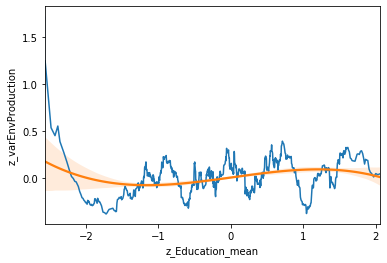

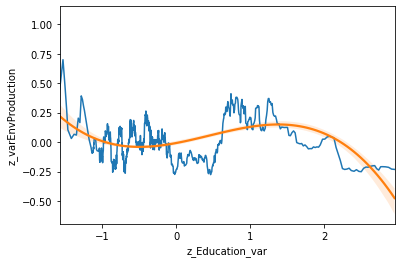

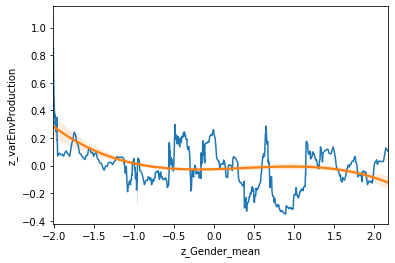

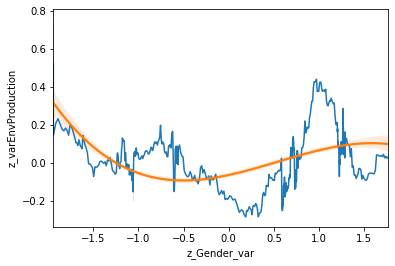

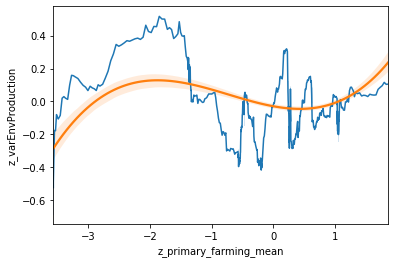

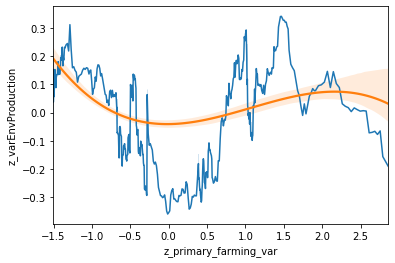

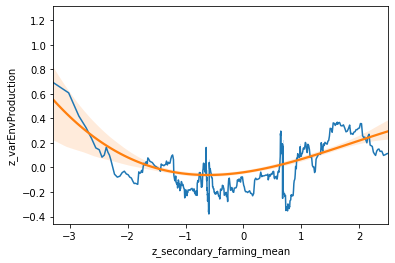

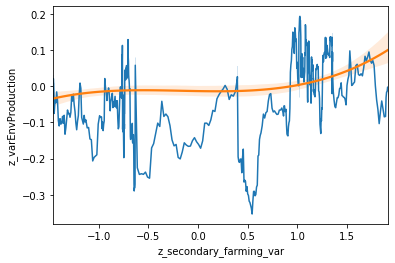

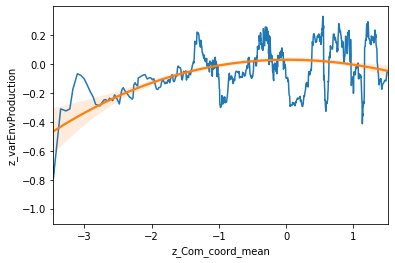

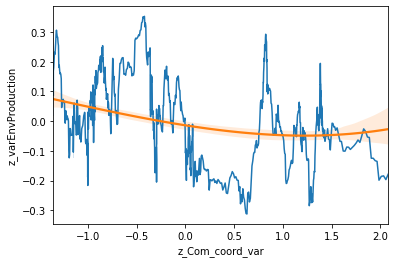

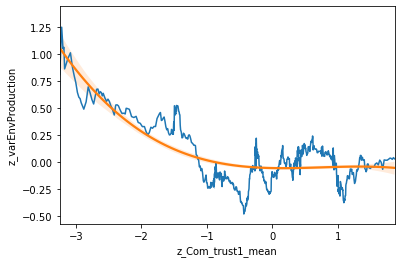

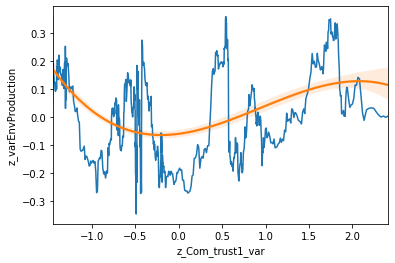

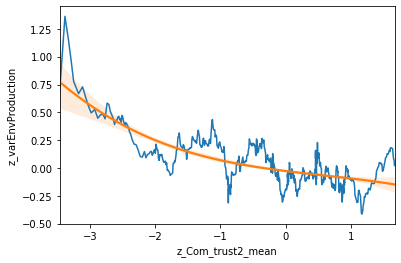

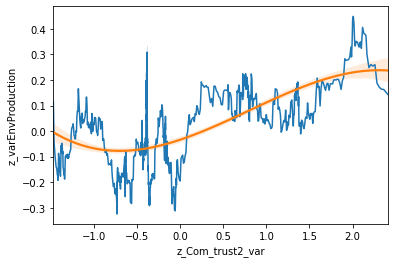

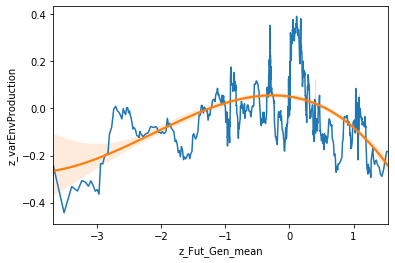

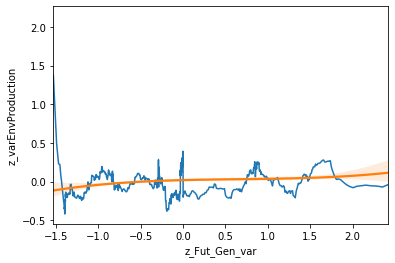

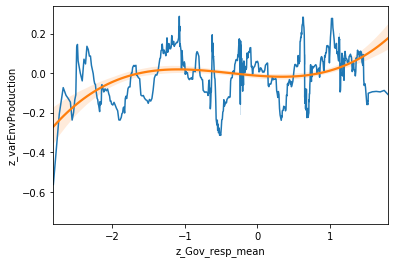

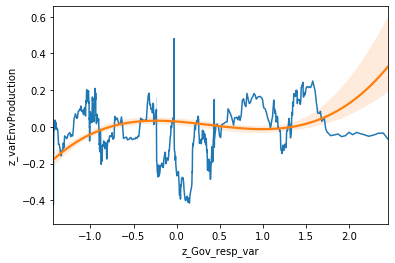

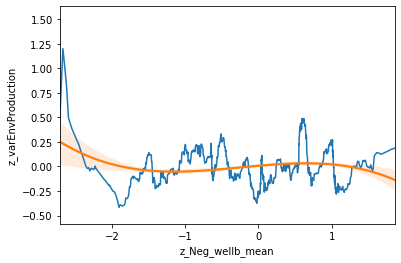

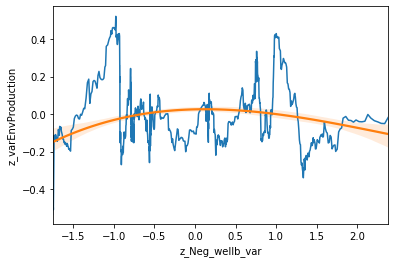

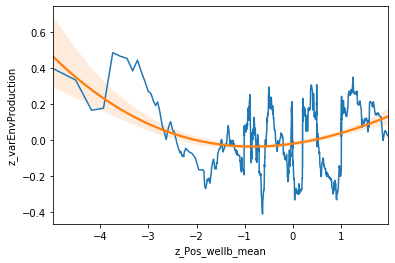

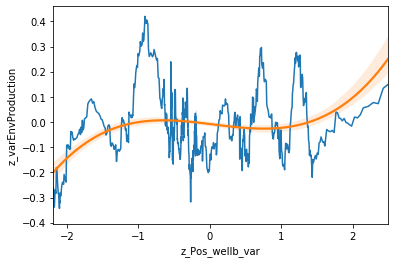

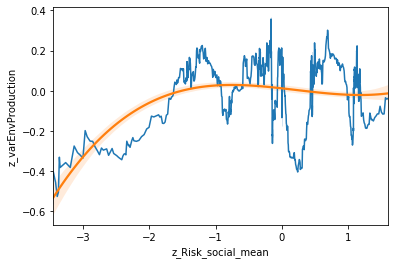

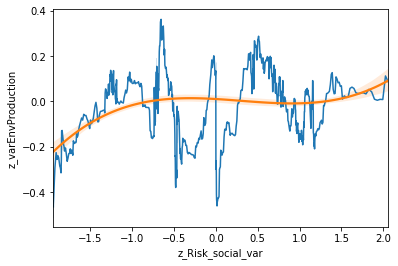

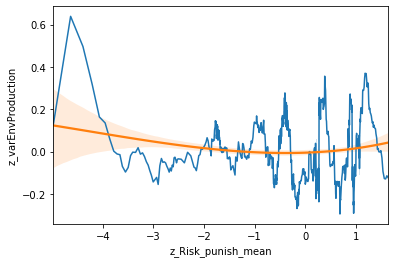

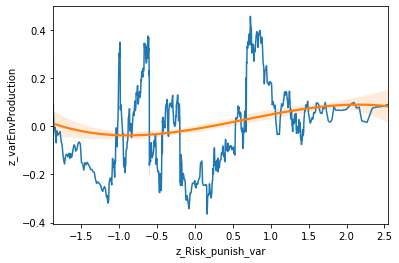

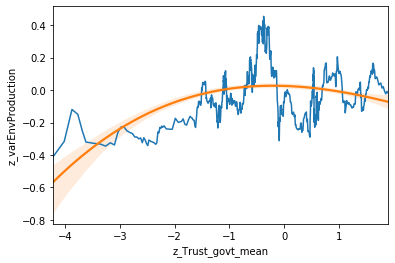

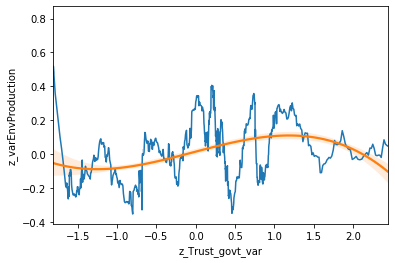

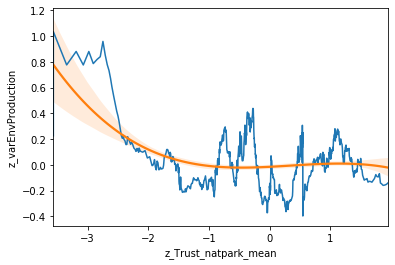

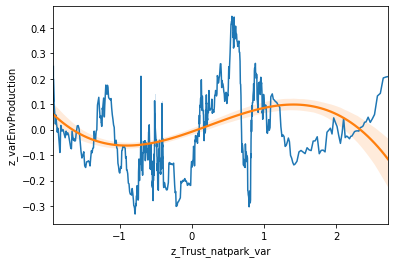

In [32]:
for var in explanatory_var:
    df = data[[var, response_var]].sort_values(by=var).rolling(window=50, min_periods=1).mean()
    sns.lineplot(x=var, y=response_var, data=df)
    sns.regplot(x=var, y=response_var, data=df, fit_reg=True, order=3, scatter=False)
    plt.show()

## Country-wise distributions of explanatory variable

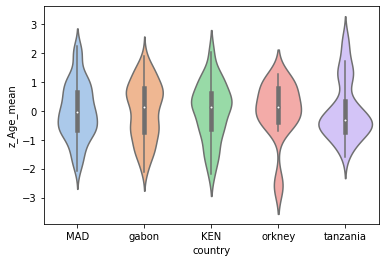

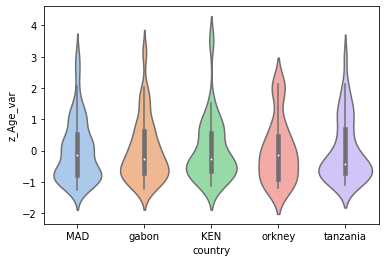

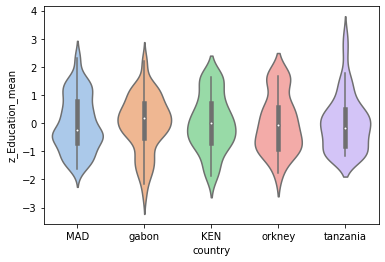

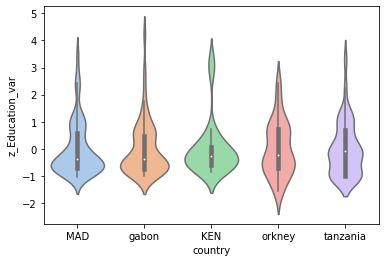

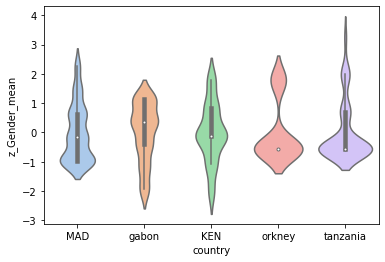

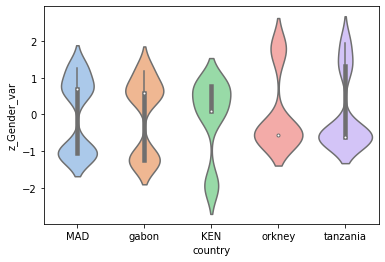

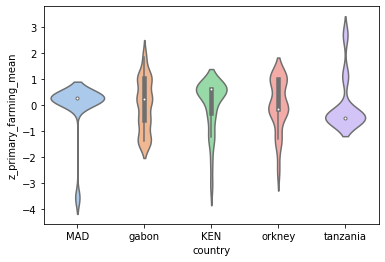

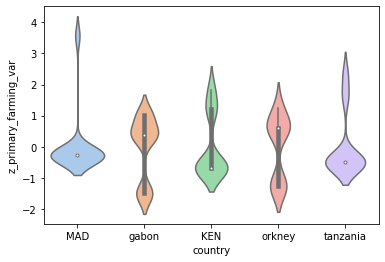

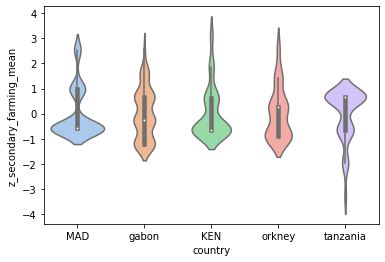

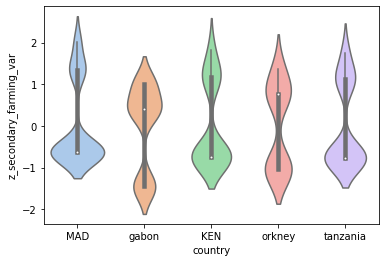

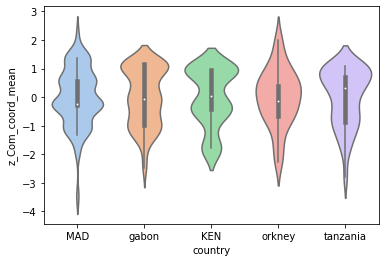

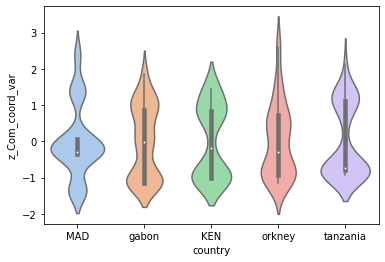

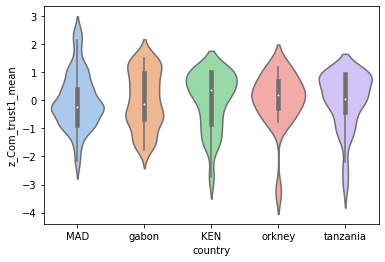

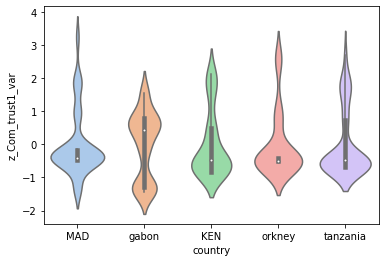

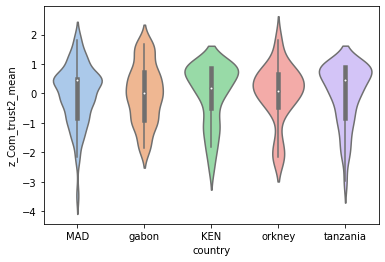

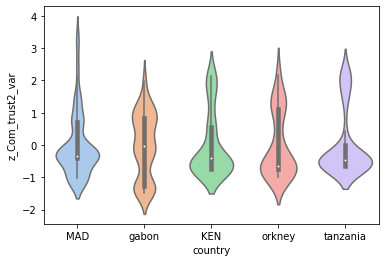

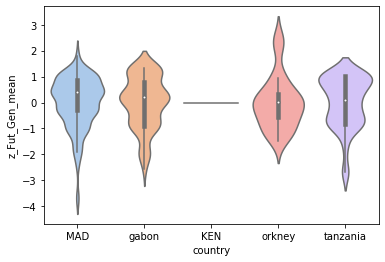

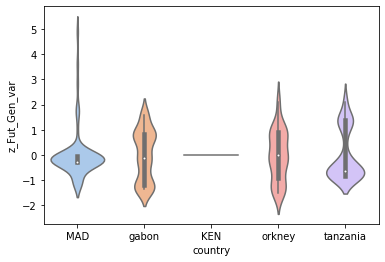

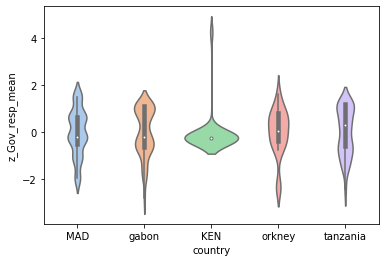

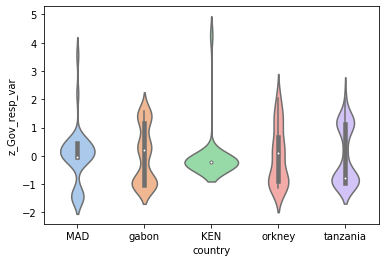

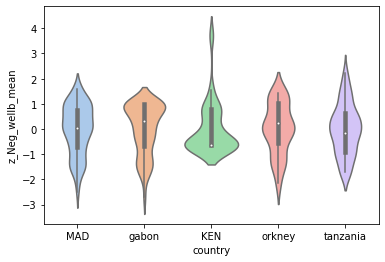

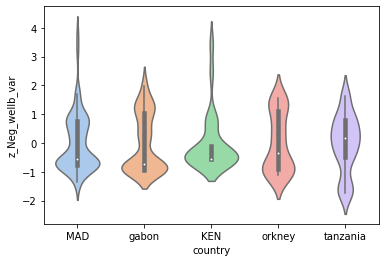

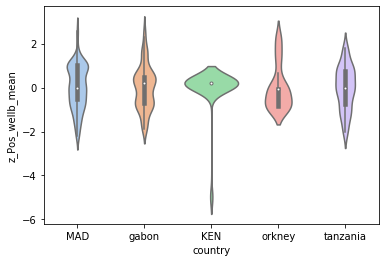

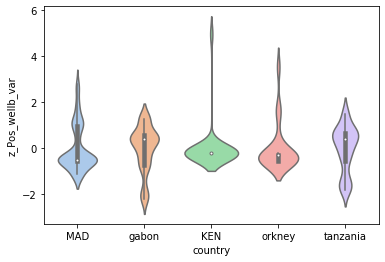

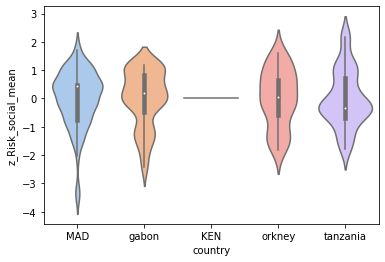

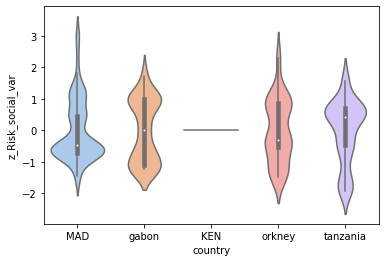

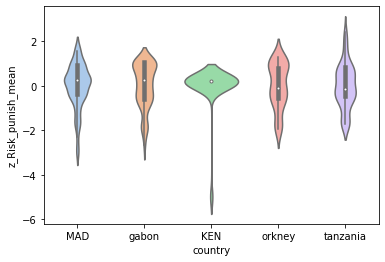

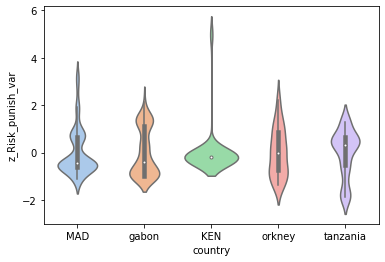

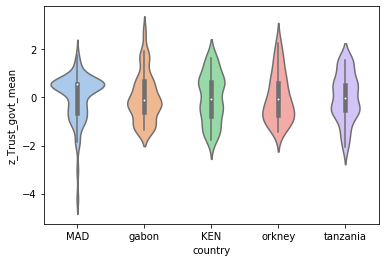

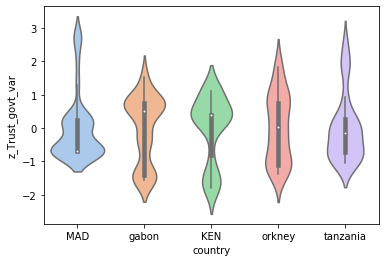

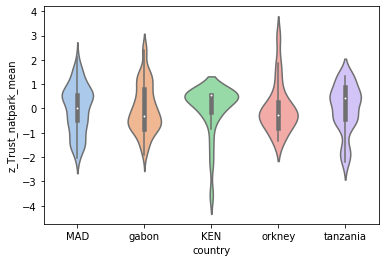

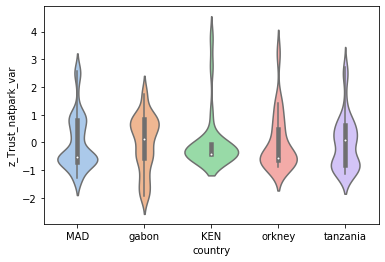

In [33]:
for var in explanatory_var:
    #df = data[[var, 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
    sns.violinplot('country', var, data=data, palette='pastel')
    plt.show()

In [34]:
"""from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(data[explanatory_var])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf.loc[:, 'principal component 1'],
           principalDf.loc[:, 'principal component 2'],
           c = data[response_var], s = 10, cmap='Blues')
ax.grid()"""

"from sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\n\nx = StandardScaler().fit_transform(data[explanatory_var])\npca = PCA(n_components=2)\nprincipalComponents = pca.fit_transform(x)\nprincipalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])\n\nfig = plt.figure(figsize = (8,8))\nax = fig.add_subplot(1,1,1) \nax.set_xlabel('Principal Component 1', fontsize = 15)\nax.set_ylabel('Principal Component 2', fontsize = 15)\nax.set_title('2 component PCA', fontsize = 20)\nax.scatter(principalDf.loc[:, 'principal component 1'],\n           principalDf.loc[:, 'principal component 2'],\n           c = data[response_var], s = 10, cmap='Blues')\nax.grid()"

In [35]:
"""# calculating beta coefficients from coefficients
beta_coef = []
for var in results.params.index.values[1:]:
    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))
beta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)
plt.figure(figsize=(20,5))
plt.bar('params', 'coefs', data=beta_coef)
plt.xticks(rotation=90)
plt.show()"""

"# calculating beta coefficients from coefficients\nbeta_coef = []\nfor var in results.params.index.values[1:]:\n    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))\nbeta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)\nplt.figure(figsize=(20,5))\nplt.bar('params', 'coefs', data=beta_coef)\nplt.xticks(rotation=90)\nplt.show()"